In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        # Extracting x and y coordinates from filename
        coords = [int(coord) for coord in self.images[idx].split('_')[:2]]
        return image, torch.tensor(coords, dtype=torch.float32)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset
dataset = CustomDataset(root_dir='/content/xyz2/xyz/apex', transform=transform)


In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **Resnet18**

In [5]:
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, 2)  # Output layer for 2 coordinates

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x
model = CustomResNet()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.0MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 2596.5216
Epoch [2/10], Loss: 357.5792
Epoch [3/10], Loss: 271.7478
Epoch [4/10], Loss: 193.4144
Epoch [5/10], Loss: 189.6620
Epoch [6/10], Loss: 172.2707
Epoch [7/10], Loss: 134.2464
Epoch [8/10], Loss: 103.7409
Epoch [9/10], Loss: 97.9420
Epoch [10/10], Loss: 72.0884


# **MobilenetV3**

In [8]:
from torchvision.models import mobilenet_v3_small
class CustomMobileNetV3(nn.Module):
    def __init__(self):
        super(CustomMobileNetV3, self).__init__()
        self.mobilenet = mobilenet_v3_small(pretrained=True)
        self.fc = nn.Linear(1000, 2)  # Output layer for 2 coordinates

    def forward(self, x):
        x = self.mobilenet(x)
        x = self.fc(x)
        return x

# Initialize model
model = CustomMobileNetV3()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 79.0MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 3093.3508
Epoch [2/10], Loss: 450.2945
Epoch [3/10], Loss: 304.7262
Epoch [4/10], Loss: 210.4437
Epoch [5/10], Loss: 148.1491
Epoch [6/10], Loss: 144.2715
Epoch [7/10], Loss: 127.2752
Epoch [8/10], Loss: 130.9740
Epoch [9/10], Loss: 109.7592
Epoch [10/10], Loss: 99.2242


In [ ]:
# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, targets in test_loader:
        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * images.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 359.5024


In [ ]:
# Saving the Model
torch.save(model.state_dict(), '/content/model.pth')

In [ ]:
import matplotlib.pyplot as plt
# Plot function
def plot_image_with_dots(image, coords):
    plt.imshow(image.permute(1, 2, 0))
    plt.scatter(coords[0], coords[1], c='red', s=25)  # Plot red dot at predicted coordinates
    plt.show()

# Evaluation and plotting
with torch.no_grad():
    for images, targets in test_loader:
        outputs = model(images)
        for i in range(len(images)):
            image = images[i]
            coords = outputs[i].numpy().astype(int)  # Predicted coordinates
            plot_image_with_dots(image, coords)

In [ ]:
!unzip /content/xyz_processed.zip -d /content/xyz2/

Archive:  /content/xyz_processed.zip
   creating: /content/xyz2/xyz/apex/
  inflating: /content/xyz2/xyz/apex/0_113_d642555c-1110-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/0_114_d6d681d2-1110-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/0_116_365de92a-1110-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/0_123_1e93be16-1113-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/0_128_72ca9efc-1111-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_100_8ff6a988-1113-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_104_75a82b42-1113-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_106_7ceccc3a-1110-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_106_855503dc-1111-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_108_26de8de8-1114-11ef-b1e0-a46bb6069316.jpg  
  inflating: /content/xyz2/xyz/apex/10_108_66e1906a-1110-11ef-b1e0-a46b

# **Testing on new images**

In [ ]:
!unzip -o eval.zip -d eval

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image: 73_102_ea6c82c2-1111-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (73, 102)
Predicted Coordinates(green): (64, 104)
Distance between original and predicted coordinates: 9.22



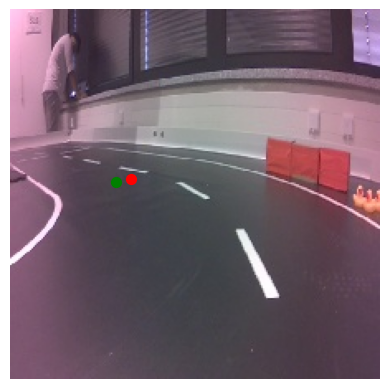

Image: 10_112_097a2f0c-1112-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (10, 112)
Predicted Coordinates(green): (9, 112)
Distance between original and predicted coordinates: 1.00



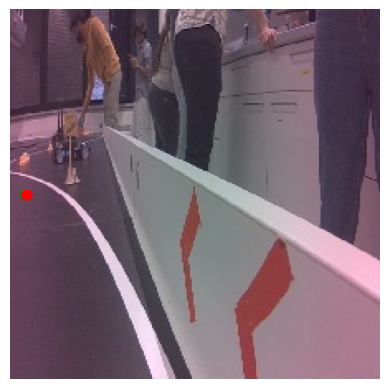

Image: 34_108_77f2427e-1114-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (34, 108)
Predicted Coordinates(green): (29, 113)
Distance between original and predicted coordinates: 7.07



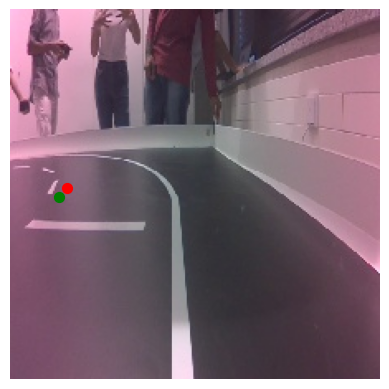

Image: 150_100_2f81d7f2-1114-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (150, 100)
Predicted Coordinates(green): (130, 104)
Distance between original and predicted coordinates: 20.40



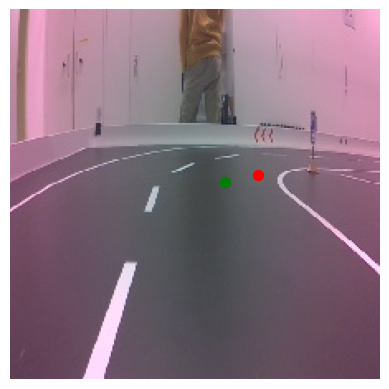

Image: 119_90_4e51024a-1112-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (119, 90)
Predicted Coordinates(green): (120, 99)
Distance between original and predicted coordinates: 9.06



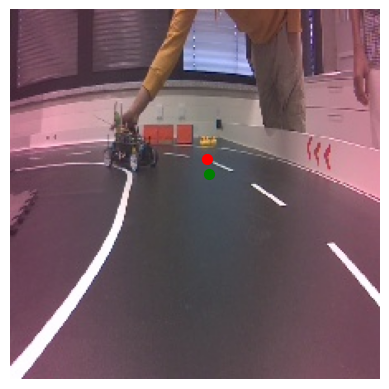

In [10]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# Load the model
#model = torch.load('/content/model.pth')
#print(model)
#model.eval()

state_dict = torch.load('/content/model_resnet18.pth')

# Create a new instance of the model
model1 = CustomResNet()

# Load the state_dict into the model
model1.load_state_dict(state_dict)

# Set the model to evaluation mode
model1.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to draw dot on image
def draw_dot(image, xy, color):
    image = image.copy()
    plt.scatter(xy[0], xy[1], c=color, s=50, marker='o')
    plt.axis('off')

# Folder containing images
folder_path = '/content/eval/eval'

resnet_distances = []
i = 0
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Load image
        img_path = os.path.join(folder_path, filename)
        image = Image.open(img_path)

        # Convert image to tensor and apply transformations
        input_image = transform(image).unsqueeze(0)

        # Extract original x and y coordinates from image name
        original_coords = [int(coord) for coord in filename.split('_')[:2]]
        original_x, original_y = original_coords

        # Predict
        with torch.no_grad():
            output = model1(input_image)

        # Extract predicted x and y coordinates
        predicted_coords = output.squeeze().cpu().numpy().astype(int)
        predicted_x, predicted_y = predicted_coords

        # Calculate distance between original and predicted coordinates
        distance = ((predicted_x - original_x)**2 + (predicted_y - original_y)**2)**0.5
        resnet_distances.append(distance)

        if i < 5:
          # Display image with dots
          plt.imshow(image)  # Convert PIL image to numpy array for imshow
          draw_dot(image, (predicted_x, predicted_y), 'green')  # Draw green dot at predicted coordinates
          draw_dot(image, (original_x, original_y), 'red')  # Draw red dot at original coordinates

          # Print original and predicted coordinates and distance
          print(f"Image: {filename}")
          print(f"Original Coordinates(red): ({original_x}, {original_y})")
          print(f"Predicted Coordinates(green): ({predicted_x}, {predicted_y})")
          print(f"Distance between original and predicted coordinates: {distance:.2f}\n")
          i = i + 1

          # Show image with dots
          plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image: 73_102_ea6c82c2-1111-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (73, 102)
Predicted Coordinates(green): (64, 102)
Distance between original and predicted coordinates: 9.00



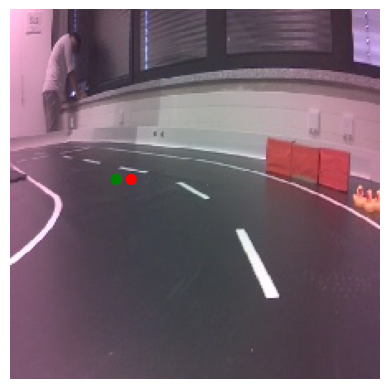

Image: 10_112_097a2f0c-1112-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (10, 112)
Predicted Coordinates(green): (12, 110)
Distance between original and predicted coordinates: 2.83



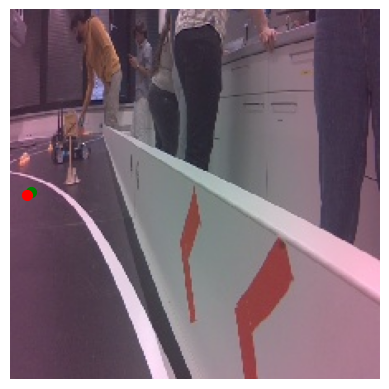

Image: 34_108_77f2427e-1114-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (34, 108)
Predicted Coordinates(green): (30, 106)
Distance between original and predicted coordinates: 4.47



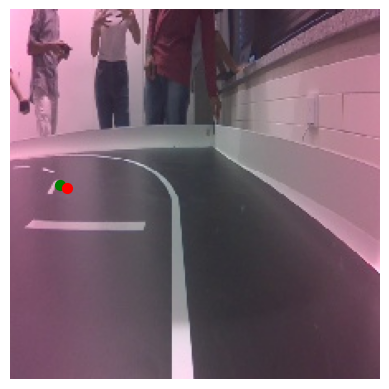

Image: 150_100_2f81d7f2-1114-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (150, 100)
Predicted Coordinates(green): (132, 105)
Distance between original and predicted coordinates: 18.68



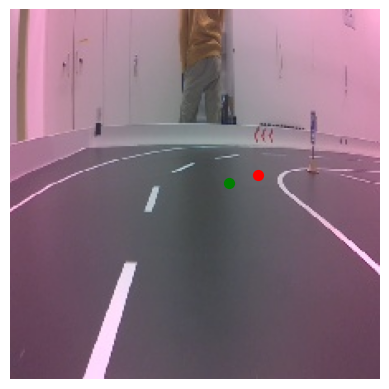

Image: 119_90_4e51024a-1112-11ef-b1e0-a46bb6069316.jpg
Original Coordinates(red): (119, 90)
Predicted Coordinates(green): (97, 97)
Distance between original and predicted coordinates: 23.09



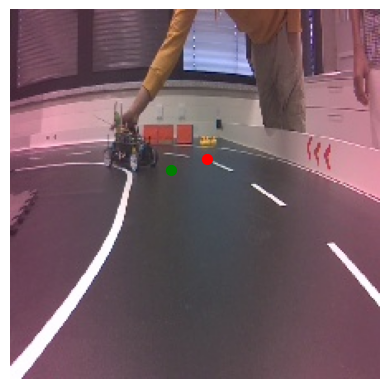

In [11]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models

# Load the model
#model = torch.load('/content/model.pth')
#print(model)
#model.eval()

state_dict = torch.load('/content/model_mobnetv3.pth')

# Create a new instance of the model
model1 = CustomMobileNetV3()

# Load the state_dict into the model
model1.load_state_dict(state_dict)

# Set the model to evaluation mode
model1.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to draw dot on image
def draw_dot(image, xy, color):
    image = image.copy()
    plt.scatter(xy[0], xy[1], c=color, s=50, marker='o')
    plt.axis('off')

# Folder containing images
folder_path = '/content/eval/eval'

mobilenetv3_distances = []
i=0
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        # Load image
        img_path = os.path.join(folder_path, filename)
        image = Image.open(img_path)

        # Convert image to tensor and apply transformations
        input_image = transform(image).unsqueeze(0)

        # Extract original x and y coordinates from image name
        original_coords = [int(coord) for coord in filename.split('_')[:2]]
        original_x, original_y = original_coords

        # Predict
        with torch.no_grad():
            output = model1(input_image)

        # Extract predicted x and y coordinates
        predicted_coords = output.squeeze().cpu().numpy().astype(int)
        predicted_x, predicted_y = predicted_coords

        # Calculate distance between original and predicted coordinates
        distance = ((predicted_x - original_x)**2 + (predicted_y - original_y)**2)**0.5
        mobilenetv3_distances.append(distance)

        if i < 5:
          # Display image with dots
          plt.imshow(image)  # Convert PIL image to numpy array for imshow
          draw_dot(image, (predicted_x, predicted_y), 'green')  # Draw green dot at predicted coordinates
          draw_dot(image, (original_x, original_y), 'red')  # Draw red dot at original coordinates

          # Print original and predicted coordinates and distance
          print(f"Image: {filename}")
          print(f"Original Coordinates(red): ({original_x}, {original_y})")
          print(f"Predicted Coordinates(green): ({predicted_x}, {predicted_y})")
          print(f"Distance between original and predicted coordinates: {distance:.2f}\n")
          i = i + 1

          # Show image with dots
          plt.show()

Average of resnet18: 14.496667442336365
Average of mobilenetv3: 14.893456536078965


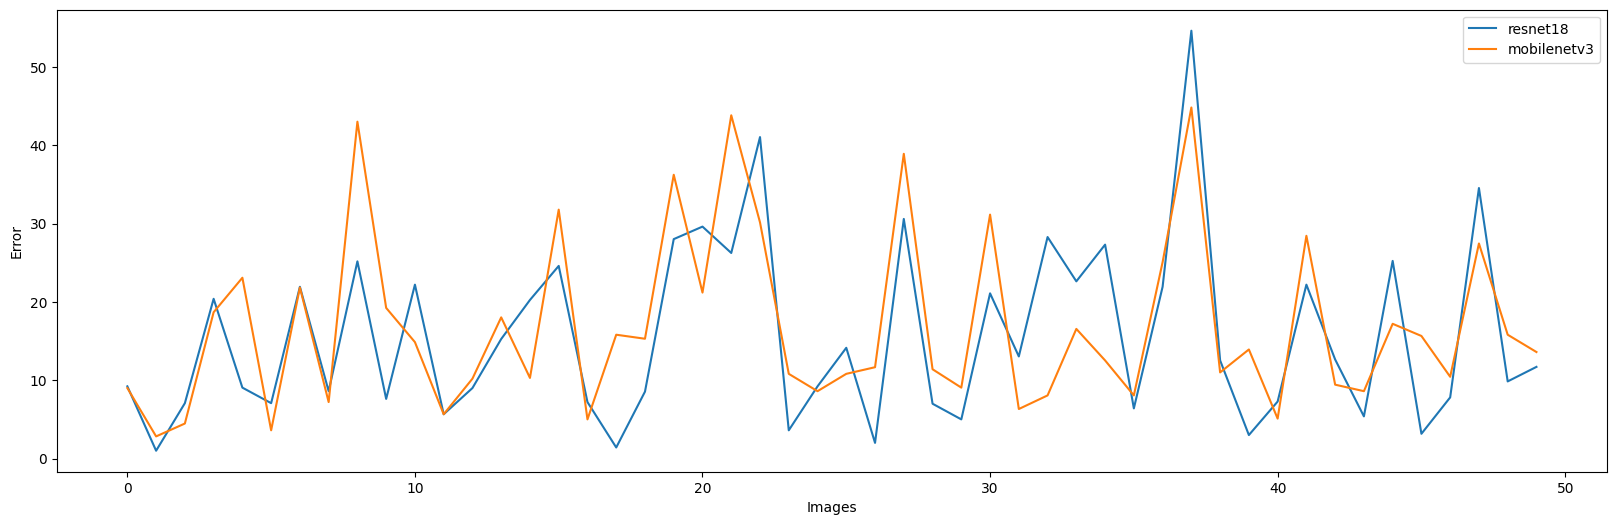

In [22]:
import numpy as np
plt.figure(figsize=(20, 6))

array1 = resnet_distances
array2 = mobilenetv3_distances

print(f"Average of resnet18: {np.mean(resnet_distances)}")
print(f"Average of mobilenetv3: {np.mean(mobilenetv3_distances)}")


array1 = array1[:50]
array2 = array2[:50]
plt.plot(array1, label='resnet18')
plt.plot(array2, label='mobilenetv3')

# Adding titles and labels
plt.xlabel('Images')
plt.ylabel('Error')

# Adding a legend
plt.legend()

# Display the plot
plt.show()